In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import h5py
import cv2 as cv


import tensorflow as tf
from tensorflow.keras.layers import Input, ZeroPadding2D, Activation, Dense, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Concatenate, SpatialDropout2D, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal, random_normal
from tensorflow.keras.losses import MSE, MAE
from tensorflow.keras.metrics import RootMeanSquaredError 
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import backend as K


In [2]:
!git clone https://github.com/juliocardenas25/Magnetic_methods.git

Cloning into 'Magnetic_methods'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 73 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [3]:
## Useful functions

from Magnetic_methods.Utils.Utils_colab import *

In [5]:
!unzip /content/Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5.zip -d Magnetic_methods/test_data/

Archive:  /content/Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5.zip
  inflating: Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5  


In [6]:
# Path to the database

hdf5_path = 'Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5'

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_dataset_train_dev_test(hdf5_path)

In [7]:
################ Confirming data retrieved shapes ###############

##### to rgb
X_train = gray_to_rgb(X_train)
X_dev = gray_to_rgb(X_dev)
X_test = gray_to_rgb(X_test)

print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_dev.shape), "X_test shape : " + str(X_test.shape)) 
print("Y_train shape : " + str(Y_train.shape), "Y_dev par shape : " + str(Y_dev.shape), "Y_test par shape : " + str(Y_test.shape)) 


X_train shape : (6720, 64, 64, 3) X_dev shape : (1920, 64, 64, 3) X_test shape : (960, 64, 64, 3)
Y_train shape : (6720, 4) Y_dev par shape : (1920, 4) Y_test par shape : (960, 4)


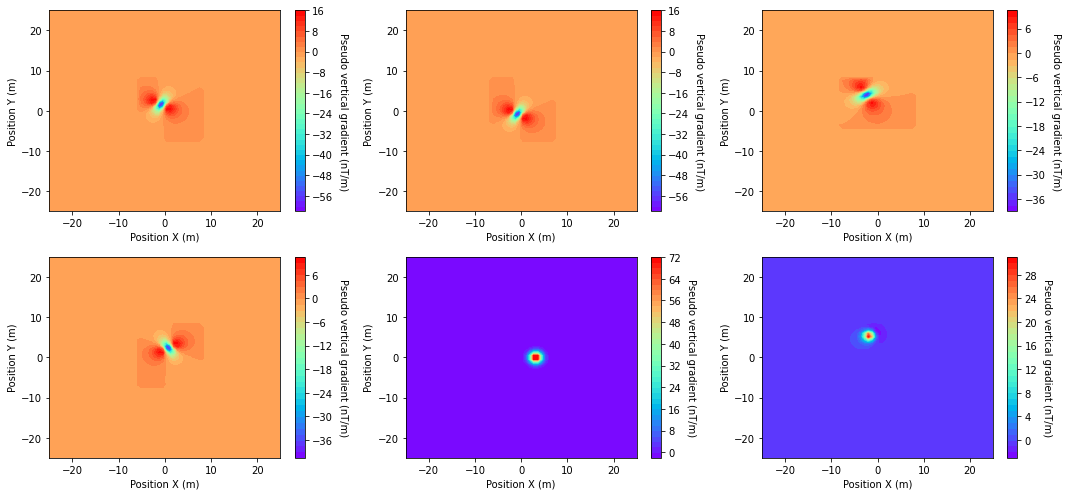

In [8]:
zmax = X_train.shape[1]
map_lenght = 25

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)


# Adjust the size of your images
plt.figure(figsize=(15,7))

# Iterate and plot random images
for i in range(6):

  n_p = int(np.random.randint(0, X_train.shape[0], 1))

  plt.subplot(2, 3, i + 1)
  plt.contourf(X, Y, X_train[n_p,:,:,0], levels = 40, cmap='rainbow')
  plt.axis('on')
  plt.xlabel('Position X (m)')
  plt.ylabel('Position Y (m)')
  clb = plt.colorbar()
  clb.set_label('Pseudo vertical gradient (nT/m)', labelpad=15, y=0.5, rotation=270)
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [9]:
# Parameters : 
# 0 = Declination
# 1 = Radius
# 2 = Depth   

Y_train_par = Y_train[:,1:3]
Y_dev_par = Y_dev[:,1:3]
Y_test_par = Y_test[:,1:3]

In [10]:
Densenet_121 = tf.keras.applications.DenseNet121(
                                                include_top=False,
                                                weights="imagenet",
                                                input_tensor=None,
                                                input_shape=X_train.shape[1:],
                                                pooling=None,
                                                classes=1000,
                                                )

#Densenet_121.summary()

29097984/29084464 [==============================] - 0s 0us/step


In [11]:
# Dense Block
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):

  '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
  concat_axis = -1

  eps = 1.1e-5
  conv_name_base = 'conv' + str(stage) + '_' + str(branch)
  relu_name_base = 'relu' + str(stage) + '_' + str(branch)

  # 1x1 Convolution (Bottleneck layer)
  inter_channel = nb_filter * 4  

  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
  x = Activation('relu', name=relu_name_base+'_x1')(x)
  x = Conv2D(inter_channel, (1,1), name=conv_name_base+'_x1', use_bias=False)(x)
  
  
  if dropout_rate:
    x = SpatialDropout2D(dropout_rate)(x)

  # 3x3 Convolution
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
  x = Activation('relu', name=relu_name_base+'_x2')(x)
  x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
  x = Conv2D(nb_filter, (3, 3), name=conv_name_base+'_x2', use_bias=False)(x)
  
  if dropout_rate:
    x = SpatialDropout2D(dropout_rate)(x)

  return x

def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
  ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
  eps = 1.1e-5

  conv_name_base = 'conv' + str(stage) + '_blk'
  relu_name_base = 'tanh' + str(stage) + '_blk'
  pool_name_base = 'pool' + str(stage) 

  concat_axis = -1

  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
  x = Activation('relu', name=relu_name_base)(x)
  x = Conv2D(int(nb_filter * compression), (1,1), name=conv_name_base, use_bias=False)(x)

  if dropout_rate:
      x = SpatialDropout2D(dropout_rate)(x)

  #x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

  return x

def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = Concatenate(axis=-1, name='concat_'+str(stage)+'_'+str(branch))([concat_feat,x])
        #concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


In [12]:
nb_dense_block=0
growth_rate=32
nb_filter=256
reduction=0.0
dropout_rate=0.0
weight_decay=1e-4

nb_layers = [6,12]

compression = 0.5

l2_regularizer = 0.005

####################

x = Densenet_121.layers[140].output

for block_idx in range(nb_dense_block):

  stage = block_idx+4
  x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

  # Add transition_block
  x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
  nb_filter = int(nb_filter * compression)

#final_stage = stage + 1
#x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

x = GlobalAveragePooling2D(name='Global_Average_Pooling_2D')(x)

x = Dense(256, kernel_initializer='GlorotUniform', kernel_regularizer=l2(l2_regularizer))(x)
x = Activation("relu")(x)

x = Dense(Y_train_par.shape[1], activation= "linear", name='rotation')(x)

model = Model(inputs = Densenet_121.input, outputs = x)

for layer in model.layers[:141]:
#for layer in position_model.layers[:9]:
  layer.trainable=True
for layer in model.layers[141:]:
#for layer in position_model.layers[9:]:
  layer.trainable=True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [13]:
def r2(y_true, y_pred):

    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)) )
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


In [14]:
model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss= MSE,
              metrics= [r2])

In [15]:
%%time
path = '/content/Densenet_par_9_TL.hdf5'

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=15, verbose=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor="val_loss", verbose=0, save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode="min",
                                                         patience=10, min_lr=0.00001, verbose=1)

####### Training #####

model.fit(X_train, Y_train_par, validation_data=(X_dev, Y_dev_par), batch_size=32, epochs=70, 
             callbacks=[earlystopping, reduce_lr, model_checkpoint])
                                                        


Epoch 1/70


KeyboardInterrupt: ignored

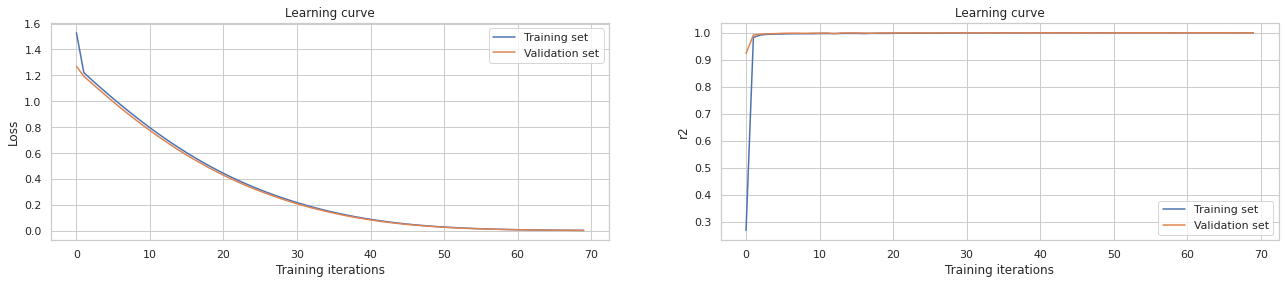

In [26]:
###################### Plotting train_val loss vs iterations #########################
fig, axs = plt.subplots(1,2, figsize=(22,4))

from_it = 0

axs[0].plot(model.history.history['loss'][from_it:])
axs[0].plot(model.history.history['val_loss'][from_it:])
axs[0].set_title('Learning curve')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training iterations')
axs[0].legend(['Training set', 'Validation set'], loc='upper right')

axs[1].plot(model.history.history['r2'][from_it:])
axs[1].plot(model.history.history['val_r2'][from_it:])
axs[1].set_title('Learning curve')
axs[1].set_ylabel('r2')
axs[1].set_xlabel('Training iterations')
axs[1].legend(['Training set', 'Validation set'], loc='lower right')

plt.show()

In [27]:
load_path = "/content/Densenet_par_9_TL.hdf5"

best_model = load_model(load_path, custom_objects={'r2': r2})


In [28]:
####### Evaluating test set ##########
train_loss= best_model.evaluate(X_train, Y_train_par, verbose=0)
dev_loss= best_model.evaluate(X_dev, Y_dev_par, verbose=0)
test_loss= best_model.evaluate(X_test, Y_test_par, verbose=0)

#print(f"Train loss = {np.round(train_loss,decimals=5)}, Train accuracy = {np.round(train_acc, decimals=3)}")
#print(f"Dev loss = {np.round(dev_loss, decimals=5)}, Dev accuracy = {np.round(dev_acc, decimals=3)}")
#print(f"Test loss = {np.round(test_loss, decimals=5)}, Test accuracy = {np.round(test_acc, decimals=3)}")

print(f"Train loss = {np.round(train_loss,decimals=5)}")
print(f"Dev loss = {np.round(dev_loss, decimals=5)}")
print(f"Test loss = {np.round(test_loss, decimals=5)}")


Train loss = [0.00416 0.99989]
Dev loss = [0.00422 0.99975]
Test loss = [0.00465 0.99863]


In [29]:
####### Predicting test set ##########

Parameters_predictions_norm = best_model.predict(X_test, verbose=0)

Y_test_par[:,0] = np.round(Y_test_par[:,0], decimals = 1)
Y_test_par[:,1] = np.round(Y_test_par[:,1], decimals = 1)
#Y_test_par[:,2] = np.round(Y_test_par[:,1], decimals = 1)

Parameters_predictions_norm[:,0] = np.round(Parameters_predictions_norm[:,0], decimals = 1)
Parameters_predictions_norm[:,1] = np.round(Parameters_predictions_norm[:,1], decimals = 1)
#Parameters_predictions_norm[:,2] = np.round(Parameters_predictions_norm[:,2], decimals = 1)


[0.1 1.6]
[0.1 1.6]


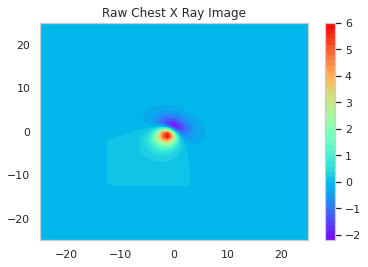

In [30]:
nn = np.random.randint(X_test.shape[0])

zmax= 32

conversion = (25*2)/zmax

sample_img = X_test[nn,:,:,0]
plt.contourf(X, Y, sample_img, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(Y_test_par[nn])
print(Parameters_predictions_norm[nn])


In [31]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_real = Y_test_par[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_real = Y_test_par[:,1]

In [32]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_predicted = Parameters_predictions_norm[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_predicted = Parameters_predictions_norm[:,1]

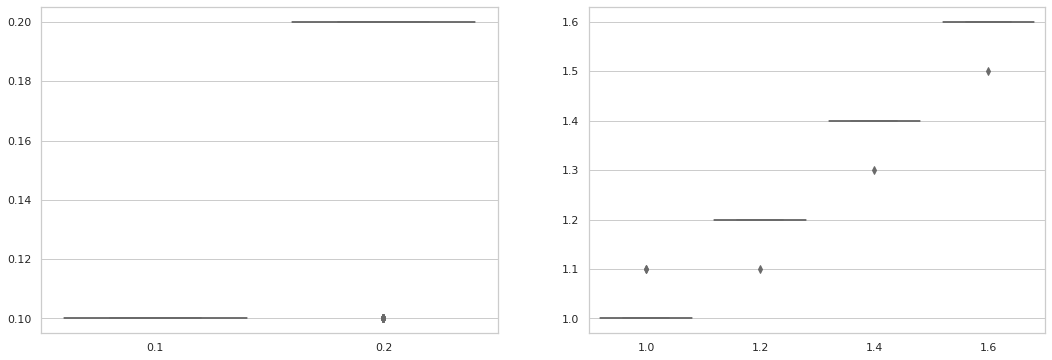

In [33]:
# Box plot visualization 

fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.set(style="whitegrid")

sns.boxplot(x=r_real[:], y=r_predicted[:], palette="Set3", ax=ax[0])

sns.boxplot(x=Depth_real[:], y=Depth_predicted[:], palette="Set3", ax=ax[1])
